In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('..')
from noise_detection.non_ride_detection import filter_known_issues
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from tueplots import bundles
from tueplots.constants.color import rgb
from matplotlib.colors import LinearSegmentedColormap

In [2]:
# Load matching candidates
matching_df = pd.read_parquet('../matching/matching_candidates_scored.parquet')
print(f"Matching candidates shape: {matching_df.shape}")

# Keep only best match per disappearance (highest prob)
matching_df = matching_df.loc[matching_df.groupby('d_idx')['prob'].idxmax()]
print(f"After filtering best matches: {matching_df.shape}")
matching_df.head()

Matching candidates shape: (45366529, 26)
After filtering best matches: (2239465, 26)


,d_idx,f_idx,provider,vehicle_type_id,d_lat,d_lon,f_lat,f_lon,d_time,f_time,...,speed,log_p_distance,log_p_speed,log_p_range,score,haversine_km,prob,prob_null,prob_forward,prob_backward
64037,170492,172162,bolt_karlsruhe,BLT:VehicleType:fdbbbf7e-e074-523b-b286-bfc8b6...,49.021660,8.413600,49.002399,8.407969,2025-10-26 14:06:01.417743,2025-10-26 14:17:01.543266,...,15.215288,-1.938024,-2.221805,-1.649500,-5.809329,NaN,0.494849,0.000136,0.494849,0.374253
49444151,170493,171990,zeus_villingen_schwenningen,ZEU:VehicleType:yimi_plus_3,48.071602,8.565970,48.066830,8.535180,2025-10-26 14:06:01.417743,2025-10-26 14:15:06.910183,...,20.986542,-2.189780,-4.153839,-3.901057,-10.244677,NaN,0.845961,0.007280,0.845961,1.000000
38490158,170494,173707,voi_de,VOJ:VehicleType:voi_scooter,48.811413,9.159269,48.847500,9.168332,2025-10-26 14:06:01.417743,2025-10-26 14:28:06.893300,...,14.204713,-3.391351,-2.163232,-2.714199,-8.268783,NaN,0.462335,0.001933,0.462335,0.278996
30831964,170495,171002,voi_de,VOJ:VehicleType:voi_scooter,49.001217,8.390921,49.000317,8.384485,2025-10-26 14:06:01.417743,2025-10-26 14:09:03.816970,...,12.236894,-0.965067,-2.288401,-1.389086,-4.642554,NaN,0.990665,0.000031,0.990665,1.000000
38490199,170496,171249,voi_de,VOJ:VehicleType:voi_scooter,48.780750,9.200260,48.787209,9.205308,2025-10-26 14:06:01.417743,2025-10-26 14:10:06.891088,...,18.331930,-0.978821,-2.927465,-1.515244,-5.421530,NaN,0.962946,0.000067,0.962946,1.000000


In [3]:
# Load vehicle events (only city column needed, use index for joining)
events_df = pd.read_parquet('../vehicle_events_export.parquet', columns=['city'])
events_df['idx'] = events_df.index
print(f"Vehicle events shape: {events_df.shape}")
events_df.head()

Vehicle events shape: (16476198, 2)


,city,idx
0,Stuttgart,0
1,Stuttgart,1
2,Stuttgart,2
3,Stuttgart,3
4,Stuttgart,4


In [4]:
# Join city column to matching data based on d_idx = idx (event index)
matching_with_city = matching_df.merge(
    events_df,
    left_on='d_idx',
    right_on='idx',
    how='left'
).drop(columns=['idx'])

print(f"Matching with city shape: {matching_with_city.shape}")
print(f"\nCity distribution:")
print(matching_with_city['city'].value_counts(dropna= False))

Matching with city shape: (2239465, 27)

City distribution:
city
Stuttgart                 557114
Zürich                    430957
Karlsruhe                 289289
Saarbrücken               177751
Reutlingen/Tübingen       142087
Mannheim                  140984
Basel                      83005
Heilbronn                  65996
Ulm                        52551
Bern                       47616
Mainz                      45662
Kaiserslautern             39709
Pforzheim                  36486
Heidelberg                 27896
St. Gallen                 26018
Friedrichshafen            21679
Freiburg                   18319
Villingen-Schwenningen     13857
Konstanz                    7713
Winterthur                  4485
Überlingen                  4449
Lindau                      3822
Bregenz                     2020
Name: count, dtype: int64


In [5]:
# Filter out known data quality issues (Saarbrücken 3am spike)
matching_filtered = filter_known_issues(matching_with_city)

# Exclude small cities (< 5000 trips)
MIN_TRIPS = 5000
city_counts = matching_filtered['city'].value_counts()
large_cities = city_counts[city_counts >= MIN_TRIPS].index
matching_filtered = matching_filtered[matching_filtered['city'].isin(large_cities)]

print(f"Excluded {len(city_counts) - len(large_cities)} cities with < {MIN_TRIPS} trips")
print(f"\nFiltered city distribution ({len(large_cities)} cities):")
print(matching_filtered['city'].value_counts())

Filtered out 37,188 trips (1.7%):
  - Saarbrücken 3am: 37,188
Excluded 4 cities with < 5000 trips

Filtered city distribution (19 cities):
city
Stuttgart                 557114
Zürich                    430957
Karlsruhe                 289289
Reutlingen/Tübingen       142087
Mannheim                  140984
Saarbrücken               140563
Basel                      83005
Heilbronn                  65996
Ulm                        52551
Bern                       47616
Mainz                      45662
Kaiserslautern             39709
Pforzheim                  36486
Heidelberg                 27896
St. Gallen                 26018
Friedrichshafen            21679
Freiburg                   18319
Villingen-Schwenningen     13857
Konstanz                    7713
Name: count, dtype: int64


# TEMPORAL ANALYSIS

In [6]:
# Convert from UTC to Central European Time (CET = UTC+1 for winter)
matching_filtered['d_time'] = pd.to_datetime(matching_filtered['d_time'])
matching_filtered['d_time'] = matching_filtered['d_time'] + pd.Timedelta(hours=1)

# Usage pattern across hours of day and weekdays/weekends
matching_filtered['hour'] = matching_filtered['d_time'].dt.hour
matching_filtered['day_of_week'] = matching_filtered['d_time'].dt.dayofweek
matching_filtered['day_type'] = matching_filtered['day_of_week'].apply(
    lambda x: 'Weekend' if x >= 5 else 'Weekday'
)

df = matching_filtered.groupby(['city', 'day_type', 'hour']).size().reset_index(name='count')

# Z-normalization across hours within each city and day type
df['mean'] = df.groupby(['city', 'day_type'])['count'].transform('mean')
df['std']  = df.groupby(['city', 'day_type'])['count'].transform('std')
df['z_score'] = (df['count'] - df['mean']) / df['std']

print(f"Temporal data prepared: {len(df)} rows")
print(f"Cities: {df['city'].nunique()}, Hours: 0-23, Day types: {df['day_type'].unique().tolist()}")

Temporal data prepared: 908 rows
Cities: 19, Hours: 0-23, Day types: ['Weekday', 'Weekend']


In [7]:
# Load POI data and compute drive intention flow
events = pd.read_parquet('../vehicle_events_export.parquet')
pois = pd.read_parquet('../spatial/pois.parquet')

# Map d_idx and f_idx to event IDs
idx_to_id = events['id'].to_dict()
matching_filtered['d_id'] = matching_filtered['d_idx'].map(idx_to_id)
matching_filtered['f_id'] = matching_filtered['f_idx'].map(idx_to_id)

# Filter to high confidence matches
MIN_PROB = 0.5
trips = matching_filtered[matching_filtered['prob'] > MIN_PROB].copy()

# Add time phase
def get_time_phase(hour):
    if 6 <= hour < 14:
        return '6-14'
    elif 14 <= hour < 22:
        return '14-22'
    else:
        return '22-6'

trips['time_phase'] = trips['hour'].apply(get_time_phase)

print(f'High confidence trips: {len(trips):,}')

High confidence trips: 1,711,267


In [8]:
# Process POIs - exclude uninformative classes
EXCLUDE_CLASSES = ['building_other', 'public_service', 'parking', 'transportation', 'amenity', 'railway']
pois_filtered = pois[~pois['class'].isin(EXCLUDE_CLASSES)].copy()

# Distance weighting
CUTOFF, MAX_DIST, MIN_WEIGHT = 30, 100, 0.5
pois_filtered['weight'] = np.where(
    pois_filtered['distance_m'] <= CUTOFF, 1.0,
    MIN_WEIGHT + (1 - MIN_WEIGHT) * (1 - (pois_filtered['distance_m'] - CUTOFF) / (MAX_DIST - CUTOFF))
)

# Aggregate to event level proportions
weighted_counts = pois_filtered.groupby(['event_id', 'class'])['weight'].sum().unstack(fill_value=0)
row_proportions = weighted_counts.div(weighted_counts.sum(axis=1), axis=0)

# Filter trips to those with POI data
trips = trips[trips['d_id'].isin(row_proportions.index) & trips['f_id'].isin(row_proportions.index)].copy()

# Key classes for analysis
KEY_CLASSES = ['residential', 'office', 'commercial', 'industrial', 'public_transport', 
               'retail', 'sustenance', 'healthcare', 'education', 'recreation', 
               'entertainment', 'sports', 'attraction']
available_classes = [c for c in KEY_CLASSES if c in row_proportions.columns]

print(f'Trips with POI data: {len(trips):,}')
print(f'Classes: {len(available_classes)}')

C:\Users\erike\AppData\Local\Temp\ipykernel_110032\1334645011.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weighted_counts = pois_filtered.groupby(['event_id', 'class'])['weight'].sum().unstack(fill_value=0)


Trips with POI data: 1,598,236
Classes: 13


In [9]:
# Compute flow by time phase and day type
TIME_PHASES = ['6-14', '14-22', '22-6']
results_weekday, results_weekend = {}, {}

for phase in TIME_PHASES:
    for day_type in ['Weekday', 'Weekend']:
        phase_trips = trips[(trips['time_phase'] == phase) & (trips['day_type'] == day_type)]
        if len(phase_trips) < 100:
            continue
        origin = row_proportions[available_classes].loc[phase_trips['d_id'].values].mean()
        dest = row_proportions[available_classes].loc[phase_trips['f_id'].values].mean()
        flow = (dest - origin) * 100
        if day_type == 'Weekday':
            results_weekday[phase] = flow
        else:
            results_weekend[phase] = flow

flow_weekday = pd.DataFrame(results_weekday)
flow_weekend = pd.DataFrame(results_weekend)

print('Flow computed for weekday and weekend by time phase')

Flow computed for weekday and weekend by time phase


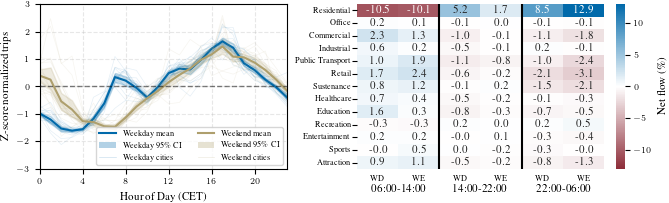

Saved: temporal_and_intention_combined.pdf/png


In [10]:
# Combined side-by-side figure: Temporal patterns + Drive intention heatmap
# Reset matplotlib to defaults before applying tueplots
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams.update(bundles.icml2024(column="full", nrows=1, ncols=2))

fig, axes = plt.subplots(1, 2)

# LEFT: Temporal z-score patterns (blue/gold like other plots)
ax1 = axes[0]
for name, main_color in [('Weekday', rgb.tue_blue), ('Weekend', rgb.tue_gold)]:
    subset = df[df['day_type'] == name]
    # Individual city lines - very transparent
    sns.lineplot(data=subset, x="hour", y="z_score", units="city", estimator=None,
                 color=main_color, alpha=0.1, lw=0.5, ax=ax1, legend=False)
    # Mean line with CI band
    sns.lineplot(data=subset, x="hour", y="z_score", color=main_color, lw=1.5,
                 errorbar=('ci', 95), ax=ax1, legend=False)

ax1.axhline(0, color='black', linestyle='--', lw=1, alpha=0.5)
ax1.set_xlim(0, 23)
ax1.set_ylim(-3, 3)
ax1.set_xticks(range(0, 24, 4))
ax1.set_xlabel("Hour of Day (CET)")
ax1.set_ylabel("Z-score normalized trips")
ax1.grid(True, linestyle='--', alpha=0.3)

# Custom legend for left plot
legend_elements = [
    Line2D([0], [0], color=rgb.tue_blue, lw=1.5, label='Weekday mean'),
    Patch(facecolor=rgb.tue_blue, alpha=0.3, label='Weekday 95\\% CI'),
    Line2D([0], [0], color=rgb.tue_blue, lw=0.5, alpha=0.2, label='Weekday cities'),
    Line2D([0], [0], color=rgb.tue_gold, lw=1.5, label='Weekend mean'),
    Patch(facecolor=rgb.tue_gold, alpha=0.3, label='Weekend 95\\% CI'),
    Line2D([0], [0], color=rgb.tue_gold, lw=0.5, alpha=0.2, label='Weekend cities'),
]
ax1.legend(handles=legend_elements, loc='lower right', ncol=2, frameon=True)

# RIGHT: Drive intention heatmap (red/blue)
ax2 = axes[1]
tue_cmap = LinearSegmentedColormap.from_list('tue_diverging', [rgb.tue_red, 'white', rgb.tue_blue])

combined = pd.DataFrame({
    'WD': flow_weekday['6-14'], 'WE': flow_weekend['6-14'],
    'WD ': flow_weekday['14-22'], 'WE ': flow_weekend['14-22'],
    'WD  ': flow_weekday['22-6'], 'WE  ': flow_weekend['22-6']
})
combined.index = combined.index.str.replace('_', ' ').str.title()

abs_max = max(abs(combined.min().min()), abs(combined.max().max()), 0.5)
sns.heatmap(combined, cmap=tue_cmap, center=0, annot=True, fmt='.1f',
            cbar_kws={'label': 'Net flow (\\%)'}, ax=ax2, vmin=-abs_max, vmax=abs_max)

n_rows = len(combined)
ax2.axvline(x=2, color='black', linewidth=1.5)
ax2.axvline(x=4, color='black', linewidth=1.5)
ax2.tick_params(left=True, bottom=False)

ax2.tick_params(axis='x', pad=1)
ax2.tick_params(axis='y', pad=1)
ax2.text(1, n_rows + 1.8, '06:00-14:00', ha='center', fontsize='medium', fontweight='bold')
ax2.text(3, n_rows + 1.8, '14:00-22:00', ha='center', fontsize='medium', fontweight='bold')
ax2.text(5, n_rows + 1.8, '22:00-06:00', ha='center', fontsize='medium', fontweight='bold')
ax2.set_ylabel('')

plt.savefig('temporal_and_intention_combined.pdf', bbox_inches='tight')
plt.savefig('temporal_and_intention_combined.png', bbox_inches='tight', dpi=300)
plt.show()

print("Saved: temporal_and_intention_combined.pdf/png")